# Universidad del Valle de Guatemala

## Facultad de Ingeniería

### Departamento de Ciencias de la Computación

**Laboratorio 8 – Detección de Anomalías con Autoencoder, Isolation Forest y LOF**

**Integrantes:**

* José Rodrigo Marchena – 22398
* Sofía Velasquez – 22049

---

## 1) Carga del conjunto de datos

Usaremos **CoverType** de UCI (vía `sklearn.datasets.fetch_covtype`), que contiene **581,012 observaciones** y **54 características** (10 numéricas continuas + 44 binarias: 4 de `Wilderness_Area` y 40 de `Soil_Type`). Mantendremos las binarias y **escalaremos solo las numéricas**, tal como se pide.  

> Variables (resumen): Elevation, Aspect, Slope, distancias a hidrología/carreteras/fuego, Hillshade (9am/noon/3pm), 4 áreas silvestres binarias y 40 tipos de suelo binarios; la **etiqueta** `Cover_Type` tiene 7 clases. 

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_covtype

# Cargar datos (X: 54 features, y: cover type [1..7])
cov = fetch_covtype(as_frame=True)
X_raw: pd.DataFrame = cov.data.copy()
y_raw: pd.Series = cov.target.copy()  # 1..7 (int)

print("Shape X:", X_raw.shape, "Shape y:", y_raw.shape)
print("Primeras columnas:", X_raw.columns[:12].tolist())

# Detectar columnas binarias por prefijo para evitar errores de nomenclatura
wild_cols = [c for c in X_raw.columns if c.startswith("Wilderness_Area")]
soil_cols = [c for c in X_raw.columns if c.startswith("Soil_Type")]
bin_cols  = wild_cols + soil_cols

# El resto de columnas se consideran numéricas
num_cols = [c for c in X_raw.columns if c not in bin_cols]

# Validaciones rápidas
print(f"Numéricas detectadas: {len(num_cols)} -> {num_cols}")
print(f"Binarias (Wilderness_Area): {len(wild_cols)}")
print(f"Binarias (Soil_Type): {len(soil_cols)}")
print(f"Total columnas: {len(num_cols)+len(bin_cols)} (esperado 54)")

# (Opcional) Asegurar que binarios sean 0/1 (aunque vengan como float)
X_raw[bin_cols] = X_raw[bin_cols].astype(int)
print("Valores únicos en algunas binarias:", {c: X_raw[c].unique()[:3] for c in bin_cols[:3]})

# Distribución de Cover_Type
print("Distribución Cover_Type (1..7):\n", y_raw.value_counts().sort_index())


Shape X: (581012, 54) Shape y: (581012,)
Primeras columnas: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1']
Numéricas detectadas: 10 -> ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Binarias (Wilderness_Area): 4
Binarias (Soil_Type): 40
Total columnas: 54 (esperado 54)
Valores únicos en algunas binarias: {'Wilderness_Area_0': array([1, 0]), 'Wilderness_Area_1': array([0, 1]), 'Wilderness_Area_2': array([0, 1])}
Distribución Cover_Type (1..7):
 Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


## 2) Etiquetado: normal vs anómalo

Normal = Cover_Type == 2 (Lodgepole Pine) y Anómalo = Cover_Type ≠ 2. Creamos y_binary en {0,1} con 1 = normal

In [4]:
y_binary = (y_raw == 2).astype(int)  # 1=normal (Lodgepole Pine), 0=anómalo (resto)

print("Proporción de normales:", y_binary.mean().round(4))
print("Conteos 0/1:\n", y_binary.value_counts())

Proporción de normales: 0.4876
Conteos 0/1:
 Cover_Type
0    297711
1    283301
Name: count, dtype: int64


## 3) División Train / Validation / Test

Para **Autoencoders**, entrenar y validar **solo con normales**; el **Test** lleva mezcla normal+anómalo para evaluar en un escenario realista. 

Propuesta:

* **Test**: 15% estratificado (mezcla).
* Del 85% restante, filtrar **solo normales** y dividir en **Train (70%)** y **Val (30%)**.
* **Escalar solo numéricas** con `StandardScaler`, **ajustando** el escalador **exclusivamente en Train (normales)**; aplicar a Val/Test; **binarias** pasan “as is”. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

# 3.1) Separar Test (15%) estratificado por normal/anómalo
idx_all = np.arange(len(X_raw))
idx_trainval, idx_test = train_test_split(
    idx_all, test_size=0.15, stratify=y_binary, random_state=RANDOM_STATE
)
X_trainval = X_raw.iloc[idx_trainval].reset_index(drop=True)
y_trainval = y_binary.iloc[idx_trainval].reset_index(drop=True)

X_test = X_raw.iloc[idx_test].reset_index(drop=True)
y_test = y_binary.iloc[idx_test].reset_index(drop=True)

# 3.2) De TrainVal, quedarnos solo con normales para Train y Val
mask_normals_tv = (y_trainval == 1)
X_trainval_normals = X_trainval.loc[mask_normals_tv].reset_index(drop=True)
y_trainval_normals = y_trainval.loc[mask_normals_tv].reset_index(drop=True)

# 3.3) Split Train (70%) y Val (30%) SOLO con normales
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval_normals, y_trainval_normals, test_size=0.30,
    random_state=RANDOM_STATE, shuffle=True
)

# 3.4) Preprocesamiento: escalar solo numéricas; binarias pasan tal cual
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_cols),
        ("bin", "passthrough", bin_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Ajustar con TRAIN (normales)
preprocess.fit(X_train)

# Transformar splits
X_train_prep = preprocess.transform(X_train)
X_val_prep   = preprocess.transform(X_val)
X_test_prep  = preprocess.transform(X_test)

print("Shapes (post-preprocess):")
print("  Train:", X_train_prep.shape, "| y_train (solo normales):", np.unique(y_train))
print("  Val  :", X_val_prep.shape,   "| y_val   (solo normales):", np.unique(y_val))
print("  Test :", X_test_prep.shape,  "| y_test (0/1 mezclado):")
print(pd.Series(y_test).value_counts())


Shapes (post-preprocess):
  Train: (168564, 54) | y_train (solo normales): [1]
  Val  : (72242, 54) | y_val   (solo normales): [1]
  Test : (87152, 54) | y_test (0/1 mezclado):
Cover_Type
0    44657
1    42495
Name: count, dtype: int64


## 3) Modelo AutoEncoder
La topologia del modelo autoencoder simetrica requiere de un cuello de botella interno, donde la cantidad de neuronas decrece hasta un punto y luego regresa a la dimension de entrada. <br>
- Topologia: 
  54 - 32 - 16 - 8- 16 - 32 - 54
- Regularizadores (solo en capas de encoding):
  - L1 de 1e-5
  - Dropout 0.2 en la etapa de encoding

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np

input_dim = X_train_prep.shape[1]
# Auntoencoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='relu',
                       activity_regularizer=regularizers.l1(1e-5)
                       )(input_layer)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(16, activation='relu',
                       activity_regularizer=regularizers.l1(1e-5)
                       )(encoded)
encoded = layers.Dropout(0.2)(encoded)
bottleneck = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(bottleneck)
decoded = layers.Dense(32, activation='relu')(decoded)
output_layer = layers.Dense(input_dim, activation='linear')(decoded)
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

# Compilar con MSE
autoencoder.compile(optimizer='adam', loss='mse')


In [69]:

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train autoencoder
history = autoencoder.fit(
    X_train_prep, X_train_prep,  # autoencoder input = output
    epochs=60,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_prep, X_val_prep),
    callbacks=[early_stop]
)

Epoch 1/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0810 - val_loss: 0.0484
Epoch 2/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0606 - val_loss: 0.0453
Epoch 3/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0555 - val_loss: 0.0412
Epoch 4/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0521 - val_loss: 0.0426
Epoch 5/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0503 - val_loss: 0.0395
Epoch 6/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0495 - val_loss: 0.0371
Epoch 7/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0489 - val_loss: 0.0378
Epoch 8/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0484 - val_loss: 0.0368
Epoch 9/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0481 - val_loss: 0.0380
Epoch 10/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0479 - val_loss: 0.0369
Epoch 11/60
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0477 - val_loss: 0.0367
Epoch 12/60
5268/52

In [70]:
autoencoder.save("autoencoder_model.keras")
import json
# Save as JSON
with open("history_autoencoder.json", "w") as f:
    json.dump(history.history, f)

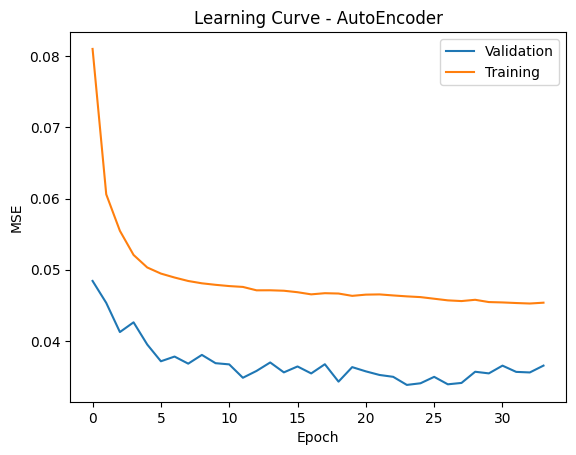

In [71]:
from matplotlib import pyplot as plt

plt.title("Learning Curve - AutoEncoder")
plt.plot(history.history["val_loss"], label="Validation")
plt.plot(history.history["loss"], label="Training")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()


In [78]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation_metrics(
    model,
    title,
    _X_test,
    _y_test
    ):
    ## Reconstruction and error
    reconstructions = model.predict(_X_test)
    errors = np.mean(np.square(_X_test - reconstructions), axis=1)
    
    ## ROC y AUC
    fpr, tpr, roc_thresholds = roc_curve(_y_test, errors)
    auc = roc_auc_score(_y_test, errors)
    plt.title(f"ROC curve - {title}")
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random chance") 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.legend()
    plt.show()
    
    j_scores = tpr - fpr
    best_roc_idx = np.argmax(j_scores)
    best_roc_thresh = roc_thresholds[best_roc_idx]
    
    ## PR curve
    precision, recall, pr_thresholds = precision_recall_curve(_y_test, errors)
    ap = average_precision_score(_y_test, errors)
    plt.title(f"PR curve - {title}")
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
    
    ## Classification report

    thresholds = np.linspace(errors.min(), errors.max(), 1000)
    best_f1 = 0
    best_thresh = 0

    for t in thresholds:
        y_pred = (errors > t).astype(int)
        f1 = f1_score(_y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    print("Best F1:", best_f1)
    print("Threshold for best F1:", best_thresh)

    y_pred = (errors > best_thresh).astype(int)

    cm = confusion_matrix(_y_test, y_pred)
    plt.title(f"Confusion Matrix - {title}")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Anomaly"],
                yticklabels=["Normal", "Anomaly"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(_y_test, y_pred, target_names=["Normal", "Anomaly"]))

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


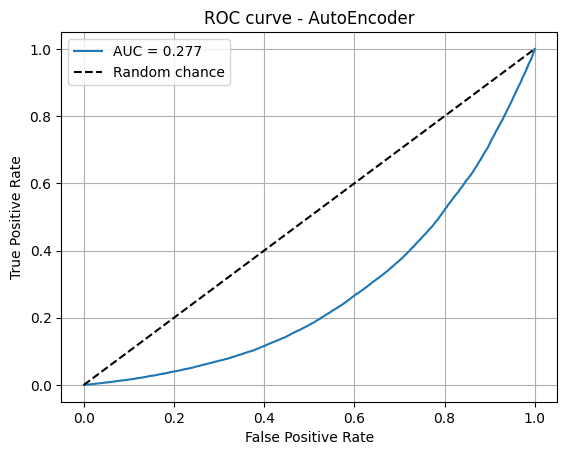

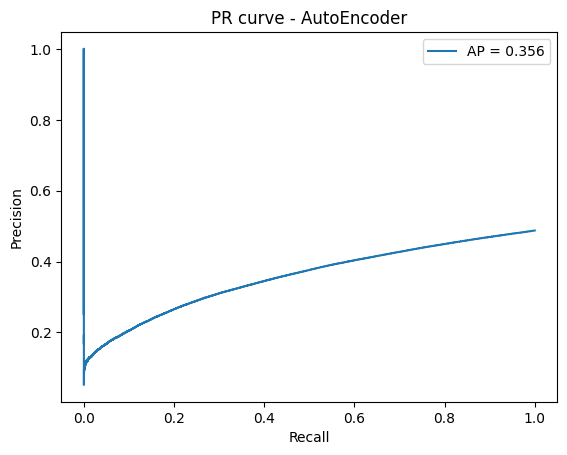

Best F1: 0.6555389290838128
Threshold for best F1: 0.0019773879534917362


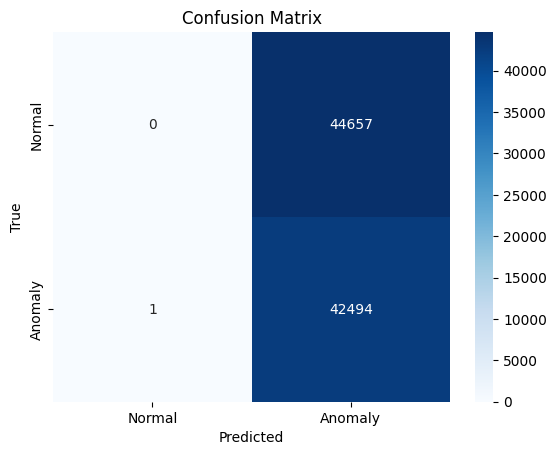

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     44657
     Anomaly       0.49      1.00      0.66     42495

    accuracy                           0.49     87152
   macro avg       0.24      0.50      0.33     87152
weighted avg       0.24      0.49      0.32     87152



In [79]:

evaluation_metrics(autoencoder,"AutoEncoder", X_test_prep, y_test)